# First model: small dataset

This notebook describes how to create a CNN for classifying dogs and cats from scratch.

In [2]:
from __future__ import print_function
import numpy as np
from keras import layers
from keras import models
from keras import optimizers
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
import matplotlib.pyplot as plt
import os

In [3]:
input_h = 150       # height
input_w = 150       # width
input_c = 3         # number of channels
save_model = True   # flag

In this case, the images of the dataset will be yield into the model using a generator. There are several advantages of using generators:

- Instead of loading the whole dataset and fed it into the model, the images are loaded in batches.
- The images can be preprocessed (rescale, grayscale, etc.) before the training step.
- The number of images can be increased via data augmentation.

In [4]:
# --- paths ---
# train (cats):       /media/data/dogs_vs_cats_small/train/cats
# train (dogs):       /media/data/dogs_vs_cats_small/train/dogs
# validation (cats):  /media/data/dogs_vs_cats_small/validation/cats
# validation (dogs):  /media/data/dogs_vs_cats_small/validation/dogs
# test (cats):        /media/data/dogs_vs_cats_small/test/cats
# test (dogs):        /media/data/dogs_vs_cats_small/test/dogs

# --- data preprocessing ---
train_datagen = ImageDataGenerator(rescale=1./255)          # rescale all images by 1/255
validation_datagen = ImageDataGenerator(rescale=1./255)

train_path = "/media/data/dogs_vs_cats_small/train"
train_generator = train_datagen.flow_from_directory(train_path,
                                                    target_size=(input_h, input_w),
                                                    batch_size=20,
                                                    class_mode="binary"
                                                    )

validation_path = "/media/data/dogs_vs_cats_small/validation"
validation_generator = validation_datagen.flow_from_directory(validation_path,
                                                            target_size=(input_h, input_w),
                                                            batch_size=20,
                                                            class_mode="binary"
                                                            )

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [5]:
# check generator
for data_batch, labels_batch in train_generator:
    print("data batch shape:  ", data_batch.shape)
    print("labels batch shape:", labels_batch.shape)
    break

data batch shape:   (20, 150, 150, 3)
labels batch shape: (20,)


In this case, the generator yields a batch of 20 images each time. The shape of each image is (150, 150, 3), that is, height=150, width=150, and channels=3. Notice that the generators modify the input images in two ways:

- The range of the images changes from [0, 255] to [0, 1] by using `rescale=1./255`.
- The shape of the images changes to `(150, 150)` by using `target_size=(input_h, input_w)`.

The generators also assign a label to each image automatically. Notice that such labels are encoded in the `class_indices` property:

In [6]:
# check labels
print("train mapping:", train_generator.class_indices)
print("validation mapping:", validation_generator.class_indices)

# mapping
class_indices = train_generator.class_indices

train mapping: {'cats': 0, 'dogs': 1}
validation mapping: {'cats': 0, 'dogs': 1}


It is worth to mention that this property will be needed later when classifying unseen images.

The next block shows how to build the model:

In [8]:
# --- build model ---
model = models.Sequential()

model.add(layers.Conv2D(32, (3, 3), activation="relu", input_shape=(input_h, input_w, input_c)))
model.add(layers.MaxPooling2D((2,2)))

model.add(layers.Conv2D(64, (3,3), activation="relu"))
model.add(layers.MaxPooling2D((2,2)))

model.add(layers.Conv2D(128, (3,3), activation="relu"))
model.add(layers.MaxPooling2D((2,2)))

model.add(layers.Conv2D(128, (3,3), activation="relu"))
model.add(layers.MaxPooling2D((2,2)))

model.add(layers.Flatten())

model.add(layers.Dense(512, activation="relu"))
model.add(layers.Dense(1, activation="sigmoid"))

The next block displays a summary of the model. Notice that the shape of the convolution/maxpooling layers changes from shallow to deep layers. From [1] page 123, the convolution layers operates on *feature maps*; they are 3D tensors of shape `(height, width, number_of_filters)`. Here, `number_of_filters` is given when the layer is defined. For instance, the feature map of the first layer has a shape `(148, 148, 32)`, that is, there are 32 filters. 

In [9]:
# check the model
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 15, 15, 128)      

In addition, we can create a figure of the model:

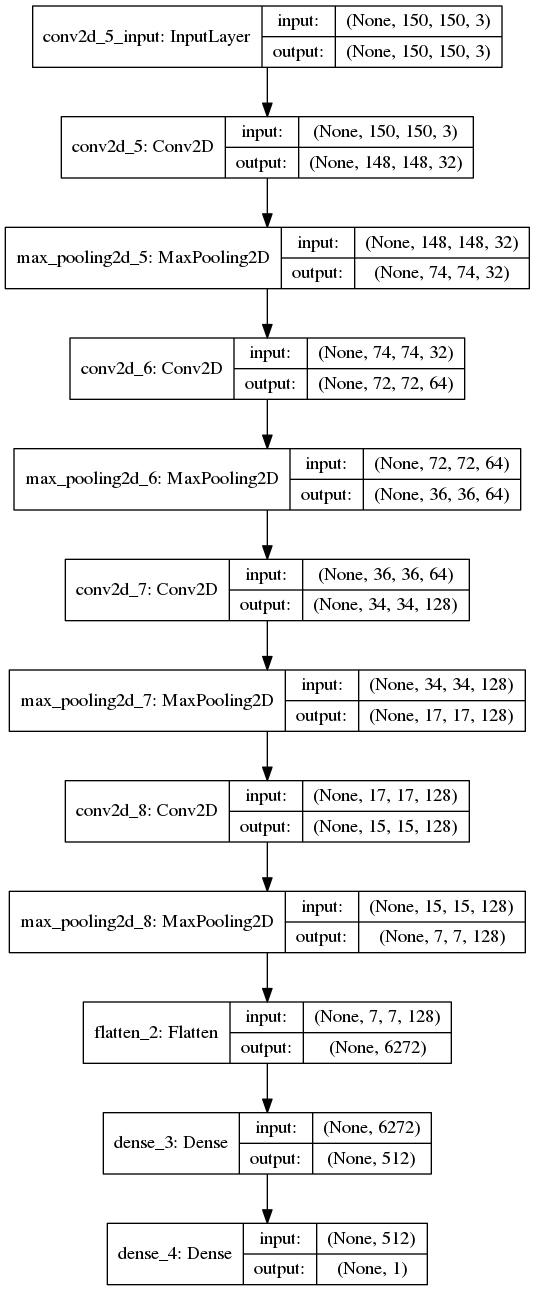

In [11]:
from keras.utils import plot_model
plot_model(model, show_shapes=True)

In [10]:
# --- compile the model ---
model.compile(loss="binary_crossentropy",
                optimizer=optimizers.RMSprop(lr=1e-4),
                metrics=["acc"])

In [11]:
# Listing 5.8 Fitting the model using a batch generator
# --- training ---
history = model.fit_generator(
            train_generator,
            steps_per_epoch=100,
            epochs=30,
            validation_data=validation_generator,
            validation_steps=50
            )

# Listing 5.9 Saving the model
# --- save model ---
if save_model:
    filename = "dogs_vs_cats_v1.h5"
    model.save(filename)
    print("model saved:", filename)

W1013 23:19:55.609534 140255455250176 deprecation_wrapper.py:119] From /home/auraham/.virtualenvs/keras/lib/python3.5/site-packages/keras/backend/tensorflow_backend.py:1033: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



Epoch 1/30
100/100 [==============================] - 67s 673ms/step - loss: 0.6892 - acc: 0.5425 - val_loss: 0.6739 - val_acc: 0.5810
Epoch 2/30
100/100 [==============================] - 69s 687ms/step - loss: 0.6546 - acc: 0.6095 - val_loss: 0.6513 - val_acc: 0.6070
Epoch 3/30
100/100 [==============================] - 63s 632ms/step - loss: 0.6129 - acc: 0.6625 - val_loss: 0.6164 - val_acc: 0.6670
Epoch 4/30
100/100 [==============================] - 63s 627ms/step - loss: 0.5752 - acc: 0.6915 - val_loss: 0.5900 - val_acc: 0.6960
Epoch 5/30
100/100 [==============================] - 63s 629ms/step - loss: 0.5364 - acc: 0.7320 - val_loss: 0.6527 - val_acc: 0.6400
Epoch 6/30
100/100 [==============================] - 63s 628ms/step - loss: 0.5102 - acc: 0.7525 - val_loss: 0.5557 - val_acc: 0.7160
Epoch 7/30
100/100 [==============================] - 63s 631ms/step - loss: 0.4748 - acc: 0.7715 - val_loss: 0.5520 - val_acc: 0.7220
Epoch 8/30
100/100 [==============================] - 6

The next block shows the accuracy and loss after training.

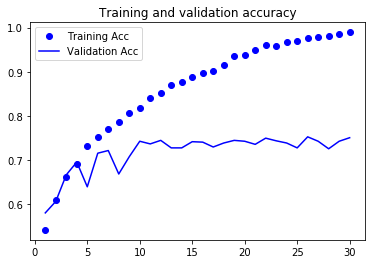

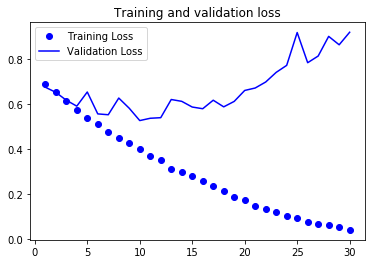

In [12]:
 # --- plotting ---
acc = history.history["acc"]
val_acc = history.history["val_acc"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, "bo", label="Training Acc")
plt.plot(epochs, val_acc, "b", label="Validation Acc")
plt.title("Training and validation accuracy")
plt.legend()

plt.figure()

plt.plot(epochs, loss, "bo", label="Training Loss")
plt.plot(epochs, val_loss, "b", label="Validation Loss")
plt.title("Training and validation loss")
plt.legend()

plt.show()

From the first figure, it seems that the model starts to overfit after the 10-th epoch.

In the following, we will classify a few images.

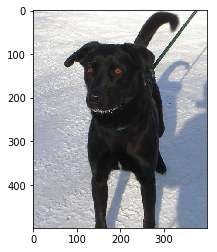

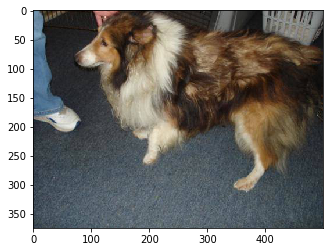

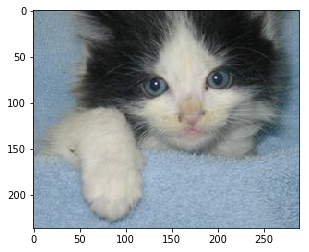

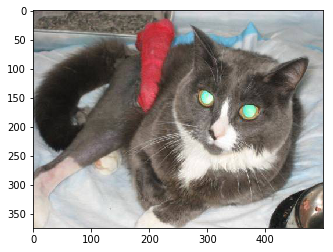

In [5]:
# --- paths ----
# train (cats):       /media/data/dogs_vs_cats_small/train/cats
# train (dogs):       /media/data/dogs_vs_cats_small/train/dogs
# validation (cats):  /media/data/dogs_vs_cats_small/validation/cats
# validation (dogs):  /media/data/dogs_vs_cats_small/validation/dogs
# test (cats):        /media/data/dogs_vs_cats_small/test/cats
# test (dogs):        /media/data/dogs_vs_cats_small/test/dogs

# --- display images (they are not preprocessed yet) ---
test_dir_cats = "/media/data/dogs_vs_cats_small/test/cats"
test_dir_dogs = "/media/data/dogs_vs_cats_small/test/dogs"

fnames_dogs = [os.path.join(test_dir_dogs, fname) for fname in os.listdir(test_dir_dogs)]
fnames_cats = [os.path.join(test_dir_cats, fname) for fname in os.listdir(test_dir_cats)]


# convert PIL to np.array (cast to np.int in the range [0, 255])
img_path = fnames_dogs[4]
img = image.load_img(img_path)
x = image.img_to_array(img).astype(int)
plt.figure()
plt.imshow(x)

# convert PIL to np.array (as np.float32 in the range [0, 1])
img_path = fnames_dogs[5]
img = image.load_img(img_path)
x = image.img_to_array(img) * 1./255
plt.figure()
plt.imshow(x)

# convert PIL to np.array (cast to np.int in the range [0, 255])
img_path = fnames_cats[4]
img = image.load_img(img_path)
x = image.img_to_array(img).astype(int)
plt.figure()
plt.imshow(x)

# convert PIL to np.array (as np.float32 in the range [0, 1])
img_path = fnames_cats[5]
img = image.load_img(img_path)
x = image.img_to_array(img) * 1./255
plt.figure()
plt.imshow(x)

plt.show()

## Image classification

In [6]:
%matplotlib inline

def display_batch(batch, label="", limit=10):
    """
    Plots the images in the batch
    """
    
    for i, img in enumerate(batch):
        
        plt.figure()
        plt.imshow(img)
        title = "class: %s id: %d" % (label, i)
        plt.title(title)
        
        if (i+1) == limit:
            break

def create_batch(fnames):
    """
    Load images from a list of file paths.
    The images are preprocessed to match the shape and size expected by the model:
      - The images are rescaled in the range [0, 1]
      - The size is (150, 150)
    The output is a tensor of shape (n_samples, height, width, n_channels)
    """
    
    images = []
    
    for fname in fnames:
        
        # convert PIL to np.array (as np.float32 in the range [0, 1])
        img = image.load_img(fname,
                            color_mode="rgb",
                            target_size=(150, 150))
        x = image.img_to_array(img) * 1./255

        images.append(x)
        
    return np.array(images)
        
test_dir_cats = "/media/data/dogs_vs_cats_small/test/cats"
test_dir_dogs = "/media/data/dogs_vs_cats_small/test/dogs"

fnames_dogs = [os.path.join(test_dir_dogs, fname) for fname in os.listdir(test_dir_dogs)]
fnames_cats = [os.path.join(test_dir_cats, fname) for fname in os.listdir(test_dir_cats)]

# create the batch for dogs and cats
batch_dogs = create_batch(fnames_dogs[:32])
batch_cats = create_batch(fnames_cats[:32])

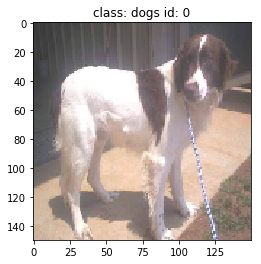

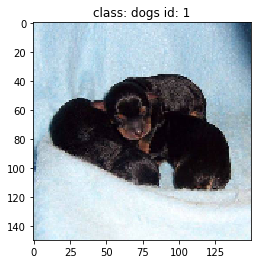

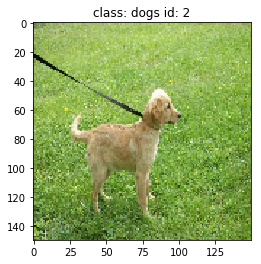

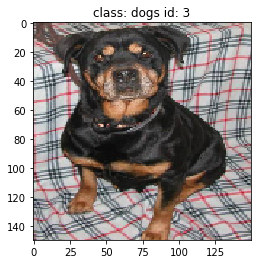

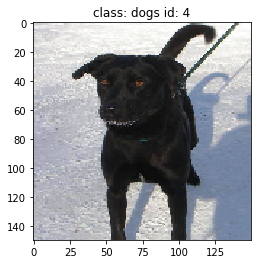

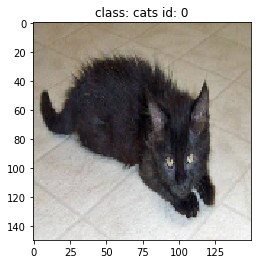

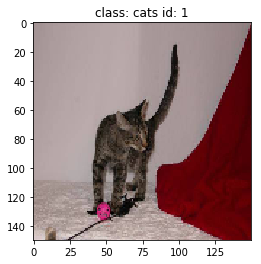

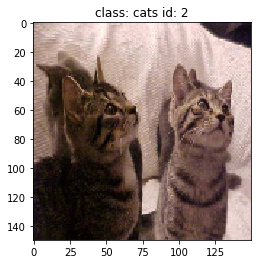

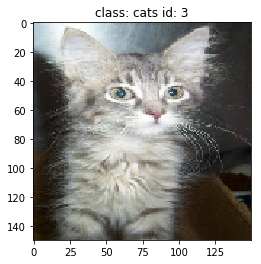

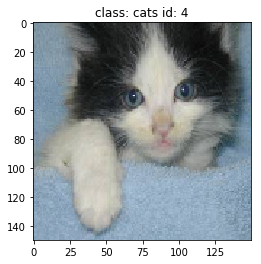

In [9]:
display_batch(batch_dogs, "dogs", limit=5)
display_batch(batch_cats, "cats", limit=5)

In [10]:
batch_dogs.shape

(32, 150, 150, 3)

In [12]:
# load model
model = load_model("dogs_vs_cats_v1.h5")

# prediction
pred_dogs = model.predict(batch_dogs)
pred_cats = model.predict(batch_cats)

In [13]:
# cast to labels
pred_dogs_classes = (pred_dogs > 0.5).astype("int32").flatten()
pred_cats_classes = (pred_cats > 0.5).astype("int32").flatten()

These are the predictions:

In [14]:
pred_dogs_classes

array([0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1,
       1, 0, 1, 0, 0, 1, 1, 1, 1, 0], dtype=int32)

In [15]:
pred_cats_classes

array([0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 0, 0, 0, 0], dtype=int32)

Remember the mapping:

In [22]:
class_indices

{'cats': 0, 'dogs': 1}

In [23]:
error_dogs = (pred_dogs_classes != class_indices["dogs"]).sum()
print("missclassified dogs:", error_dogs)

missclassified dogs: 14


In [24]:
error_cats = (pred_cats_classes != class_indices["cats"]).sum()
print("missclassified cats:", error_cats)

missclassified cats: 7


## Single image classification


Now, rather than classify a batch of images, let's classify a single image at a time.

In [16]:
# load model
model = load_model("dogs_vs_cats_v1.h5")

Remember the mapping:

In [26]:
# mapping
class_indices

{'cats': 0, 'dogs': 1}

In [40]:
# reversed mapping
rev_class_indices = {v:k for k, v in class_indices.items()}

In [54]:
def classify_single_image(img_path):
    
    # load first image (no preprocessing)
    img_original = image.load_img(img_path)
    
    # load first image
    img = image.load_img(img_path, 
                         color_mode="rgb",
                         target_size=(150, 150))

    # convert PIL to np.array (as np.float32 in the range [0, 1])
    x = image.img_to_array(img) * 1./255
    
    # change shape to (1, height, width, n_channels)
    input = np.array([x])
    
    # predict
    pred = model.predict(input)

    # cast prediction to label
    pred_label = (pred > 0.5).astype("int32").flatten()[0]  # [0] to access to the first and only image in the batch
    pred_value = pred.flatten()[0]

    # results
    label = rev_class_indices[pred_label]
    print("prediction (float): %.4f, class (int): %d, label: %s" % (pred_value, pred_label, label))

    # plot
    fig = plt.figure()
    ax = fig.add_subplot(111)
    title = "Prediction: %s" % label
    
    ax.set_title(title)
    ax.imshow(img_original)

prediction (float): 0.9994, class (int): 1, label: dogs


<IPython.core.display.Javascript object>


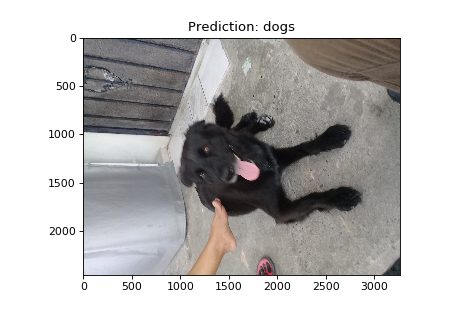

In [55]:
classify_single_image("hachi.jpg")

prediction (float): 0.0064, class (int): 0, label: cats


<IPython.core.display.Javascript object>


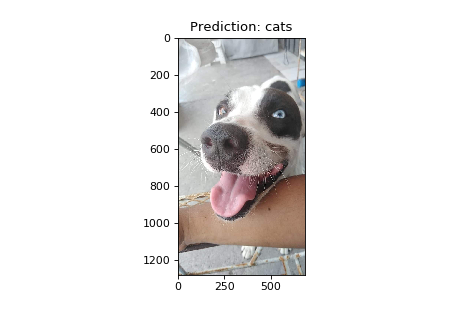

In [56]:
classify_single_image("sheldon.jpg")

So, it turns out that Hachi is indeed a dog, and Sheldon is a kind of cat. 